In [1]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Data Preparation for Model Training

### Data Reading

In [3]:
start_date = '2016-01-01'
finish_date = '2021-03-01'

price = pd.read_csv("../data generators/generated_price_data/btc-usd_daily.csv")
price = price[['market','day','close']]
price.index = price['day']
price = price[(price['day'] >= start_date) & (price['day'] <= finish_date)]

g_trends = pd.read_csv("../data generators/generated_trends_data/bitcoin_daily.csv")
g_trends = g_trends[['keyword','day','trend']]
g_trends.index = g_trends['day']
g_trends = g_trends[(g_trends['day'] >= start_date) & (g_trends['day'] <= finish_date)]

g_trends2 = pd.read_csv("../data generators/generated_trends_data/coinbase_daily.csv")
g_trends2 = g_trends2[['keyword','day','trend']]
g_trends2.index = g_trends2['day']
g_trends2 = g_trends2[(g_trends2['day'] >= start_date) & (g_trends2['day'] <= finish_date)]

w_pageview = pd.read_csv("../data generators/generated_wiki_pageview_data/Bitcoin_daily.csv")
w_pageview = w_pageview[['article','day','pageview']]
w_pageview.index = w_pageview['day']
w_pageview = w_pageview[(w_pageview['day'] >= start_date) & (w_pageview['day'] <= finish_date)]

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Feature Extraction
def create_features(data,key_val,window_len):
    features = np.zeros((1,window_len))
    for t in range(data.shape[0]-window_len):
        d = data[key_val].values[t:t+window_len].reshape(1,window_len)
        
        #Normalization to z-scores
        d = (d-d.mean())/np.std(d)
        features = np.concatenate((features,d))
    return features[1:,:]

preds = dict()
window_len_list = [14,30] #,60,120,240,365]
for window_len in window_len_list:
    print('window_len',window_len)
    price_features = create_features(price,'close',window_len)
    g_trends_features = create_features(g_trends,'trend',window_len)
    g_trends2_features = create_features(g_trends2,'trend',window_len)
    w_pageview_features = create_features(w_pageview,'pageview',window_len)

    features = np.hstack((price_features,g_trends_features,g_trends_features,w_pageview_features))
    features_small = price_features
    
    ### Assigning Class Labels

    returns = (price['close'] / price['close'].shift(1))-1
    returns = returns[window_len:]
    classes = np.array([ 1 if r >= 0 else -1 for r in returns ])
    classes = classes.reshape(classes.shape[0],1)
    classes.shape

    ### Model Training & Hyperparameter Tuning

    #features_dict = {'all':features,'price':features_small}
    features_dict = {'all':features}
    for features_k in features_dict.keys():
        print('features',features_k)
        features = features_dict[features_k]
        train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
        x_train = features[:train_len,:]
        y_train = classes[:train_len,:]

        x_test = features[train_len:,:]
        y_test = classes[train_len:,:]

        random_grid = {'n_estimators': [50,100,150,200,250],
                       'max_features': ['auto','sqrt'],
                       'max_depth': [10,20,30,40,50,None],
                       'min_samples_split': [5,10,20],
                       'min_samples_leaf': [1,5,10],
                       'bootstrap': [True,False]}

        rf = RandomForestClassifier()
        rf_random = RandomizedSearchCV(estimator = rf, 
                                       param_distributions = random_grid, 
                                       n_iter = 50, 
                                       cv = 5, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs = -1)
        #Fit the random search model
        rf_random.fit(x_train, y_train)

        model = RandomForestClassifier(n_estimators=rf_random.best_params_['n_estimators'],
                                       min_samples_split=rf_random.best_params_['min_samples_split'],
                                       min_samples_leaf=rf_random.best_params_['min_samples_leaf'],
                                       max_features=rf_random.best_params_['max_features'],
                                       max_depth=rf_random.best_params_['max_depth'],
                                       bootstrap=rf_random.best_params_['bootstrap'])
        model.fit(x_train,y_train)

        print('\ttraining score:',model.score(x_train, y_train))
        print('\ttest score:',model.score(x_test,y_test))
        
        preds['rf_w'+str(window_len)+'_feature_'+features_k] = model.predict(x_test)[1:]

window_len 7
features all
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   19.7s finished


	training score: 0.7226428079834825
	test score: 0.5573770491803278
window_len 10
features all
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   22.7s finished


	training score: 0.6137931034482759
	test score: 0.5526932084309133


## Momentum with Random Forest 

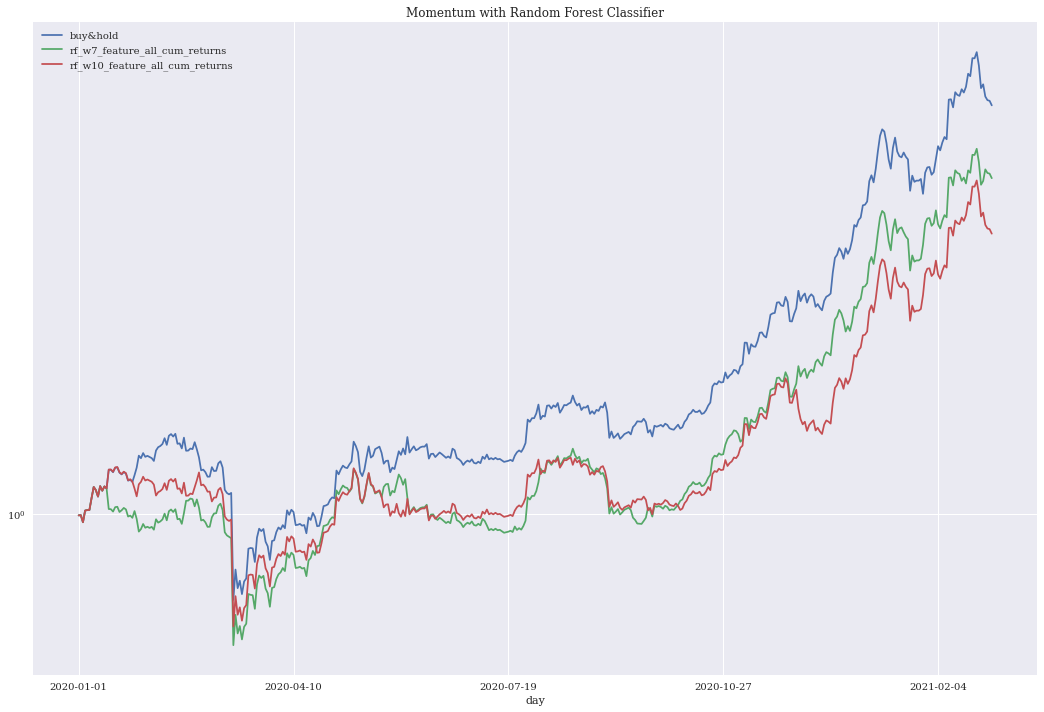

In [10]:
#take proportion of the data
test_data = price[(price['day'] >= '2019-12-31')]

#find buy&hold strategy returns
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()
returns_data = test_data[['returns','buy&hold']].copy()


#find returns
test_data = price[(price['day'] >= '2019-12-31')]
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
for kp in preds.keys():
    test_data[kp+'_returns'] = preds[kp] * test_data['returns']
test_data['random_strategy'] = np.where(np.random.rand(test_data.shape[0]) < 0.5, -1, 1)
test_data['random_strategy_returns'] = test_data['random_strategy'] * test_data['returns']

#find cumulative returns
test_data = test_data[test_data['day'] >= '2020-01-01']
for kp in preds.keys():
    returns_data[kp+'_returns'] = test_data[kp+'_returns'].values
    returns_data[kp+'_cum_returns'] = (1+returns_data[kp+'_returns'].values).cumprod()
returns_data['random_strategy_cum_returns'] = (1+test_data['random_strategy_returns'].values).cumprod()
    
plot_title = "Momentum with Random Forest Classifier"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][:]#+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

#plot_columns2 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][4:-2]+['random_strategy_cum_returns']
#ax = returns_data[plot_columns2].plot(title=plot_title,figsize=(18, 12))
#ax.get_legend()

#plot_columns3 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][-2:]+['random_strategy_cum_returns']
#ax = returns_data[plot_columns3].plot(title=plot_title,figsize=(18, 12))
#ax.get_legend()

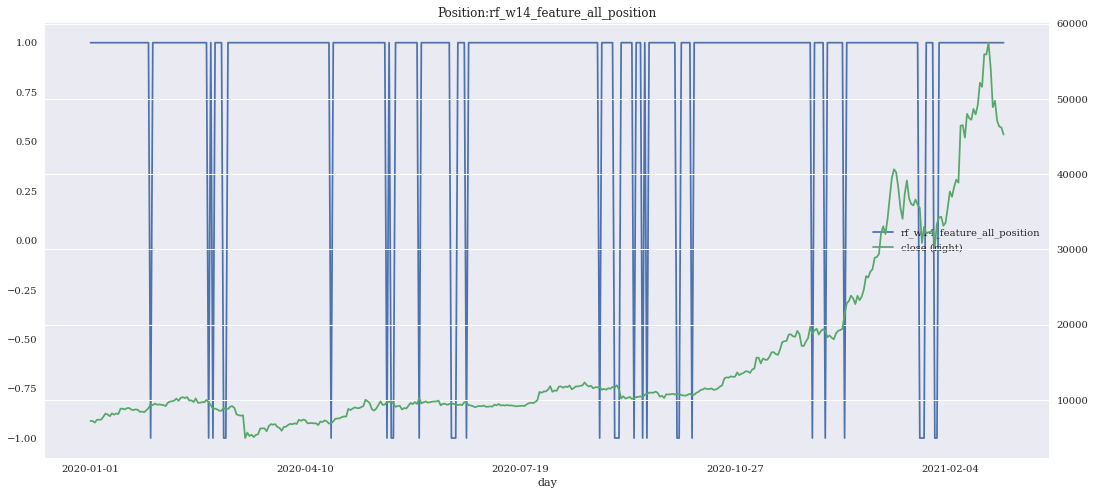

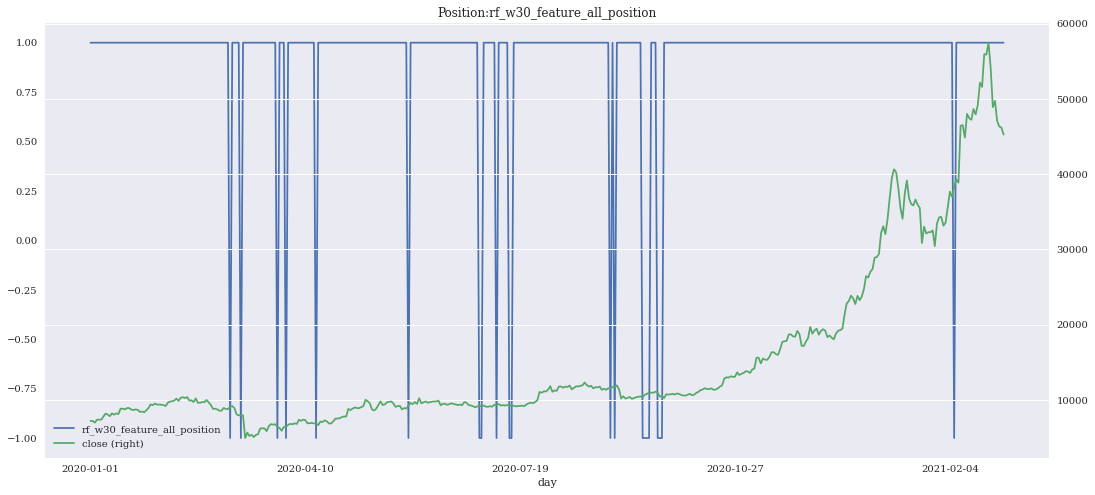

In [7]:
for kp in preds.keys():
    test_data[kp+'_position'] = preds[kp]
    ax = test_data[[kp+'_position','close']].plot(title='Position:'+kp+'_position',secondary_y='close',figsize=(18, 8))

In [8]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 3,
 'bootstrap': True}

In [7]:
### Feature Importance Analysis

# 1st 30 -> price features
# 2nd 30 -> google trend kw:bitcoin
# 3rd 30 -> google trend kw:coinbase
# 4th 30 -> wikipedia pageview article: Bitcoin
def print_feature_ranking(model,window_len,feature_count=10,is_print=True):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    def decode_feature_name(i):
        if i >= 0 and i < window_len:
            return "p(t-"+str(window_len-i)+")"
        elif i >= window_len and i < window_len*2:
            return "gtb(t-"+str(window_len-i%window_len)+")"
        elif i >= window_len*2 and i < window_len*3:
            return "gtc(t-"+str(window_len-i%window_len)+")"
        elif i >= window_len*3 and i <window_len*4:
            return "wpb(t-"+str(window_len-i%window_len)+")"

    feature_names = [decode_feature_name(i) for i in indices]

    # Print the feature ranking
    if is_print:
        print("Feature ranking:")
        for f in range(window_len*4):
            print("%d. feature[%d]: %s  (%f) " % (f + 1, indices[f], feature_names[f],importances[indices[f]]))
    
    return feature_names[:feature_count],[importances[indices[i]] for i in range(feature_count)]

<BarContainer object of 10 artists>

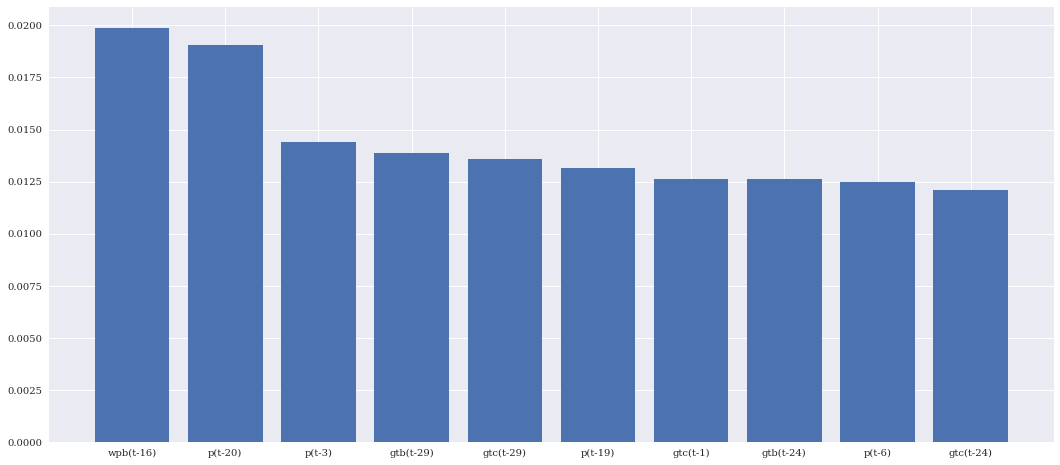

In [11]:
feature_names,importances = print_feature_ranking(model,30,10,False)
plt.figure(figsize=(18,8))
#plt.title()
plt.bar(feature_names,importances)